# Testing the Neuro-Fuzzy Classifier with the Iris Dataset
This notebook uses the Iris dataset to test that the neuro-fuzzy classifier model is working correctly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
X, classes = iris.data, iris.target

# convert target to one hot vectors
Y = np.zeros((150, 3))
Y[np.arange(150), classes] = 1

# whiten the data
# x = (x - np.mean(x, axis=0, keepdims=True)) / np.std(x, axis=0, keepdims=True)

The dataset is loaded from the sklearn library.

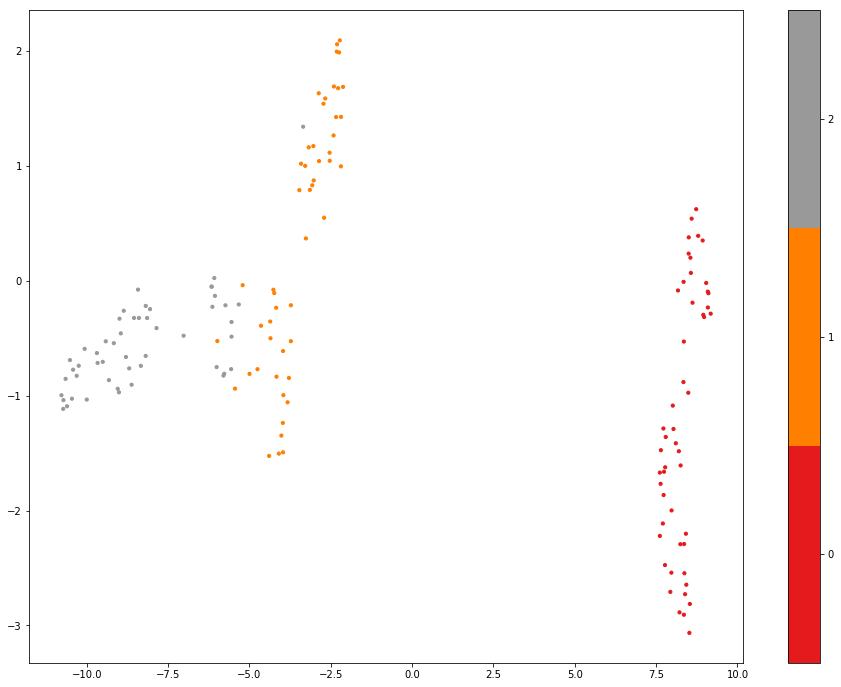

In [2]:
import os
import pickle
from umap import UMAP

_cache_dir = "cache/umap.pickle"
_ignore_cache = False

if not os.path.isfile(_cache_dir) or _ignore_cache:
    umap_reducer = UMAP(random_state=42).fit(X)
    pickle.dump(umap_reducer, open(_cache_dir, "wb"))
else:
    umap_reducer = pickle.load(open(_cache_dir, "rb"))

umap_data = umap_reducer.transform(X)

plt.figure(figsize=(16, 12))
plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))

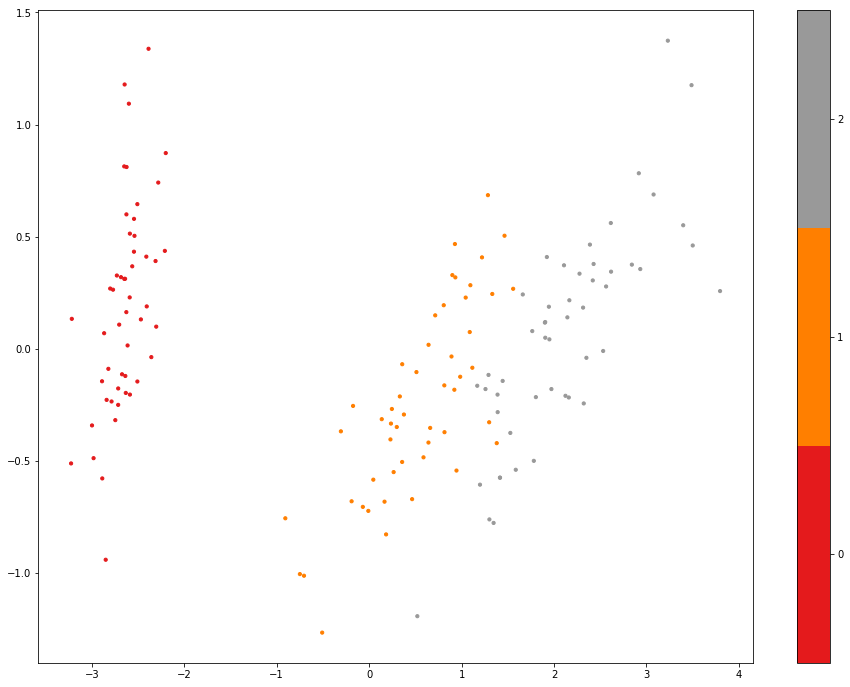

In [3]:
from sklearn.decomposition import PCA

_cache_dir = "cache/pca.pickle"
_ignore_cache = False

if not os.path.isfile(_cache_dir) or _ignore_cache:
    pca_reducer = PCA(n_components=2, random_state=42).fit(X)
    pickle.dump(pca_reducer, open(_cache_dir, "wb"))
else:
    pca_reducer = pickle.load(open(_cache_dir, "rb"))

pca_data = pca_reducer.transform(X)

plt.figure(figsize=(16, 12))
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))

A UMAP and PCA embedding are created to visualize the data and the clusters in 2 dimensions.

In [4]:
import keras
import keras.layers as layers
import keras.models as models
from keras import backend as K


# custom layer for gauss membership function
class GaussMembership(layers.Layer):
    
    def __init__(self, num_rules, epsilon=1e-8, **kwargs):
        self.epsilon = epsilon
        self.num_rules = num_rules
        super(GaussMembership, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(self.num_rules, input_shape[1]),
            initializer=keras.initializers.Zeros(),
            trainable=True)
        self.sigma = self.add_weight(
            name="sigma",
            shape=(self.num_rules, input_shape[1]),
            initializer=keras.initializers.Ones(),
            constraint=keras.constraints.NonNeg(),
            trainable=True)
        super(GaussMembership, self).build(input_shape)
    
    
    def call(self, x):
        x = K.expand_dims(x, axis=1)
        x = K.square((x - self.mu) / (self.sigma + self.epsilon))
        return K.exp(-0.5 * x)
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_rules, input_shape[1])
    

# create the model with the given parameters
def create_model(num_rules=10):
    
    def log_prod(x):
        x = K.sum(K.log(x + 1e-8), axis=2)
        x = x - K.max(x, axis=1, keepdims=True)
        return K.exp(x)
    
    return keras.Sequential([
        GaussMembership(num_rules, input_shape=(4,)),
        layers.Lambda(lambda x: log_prod(x)),
        layers.Dense(3, activation="sigmoid"),
    ])

Using TensorFlow backend.


The model is defined in keras and a helper function is written to construct the model.

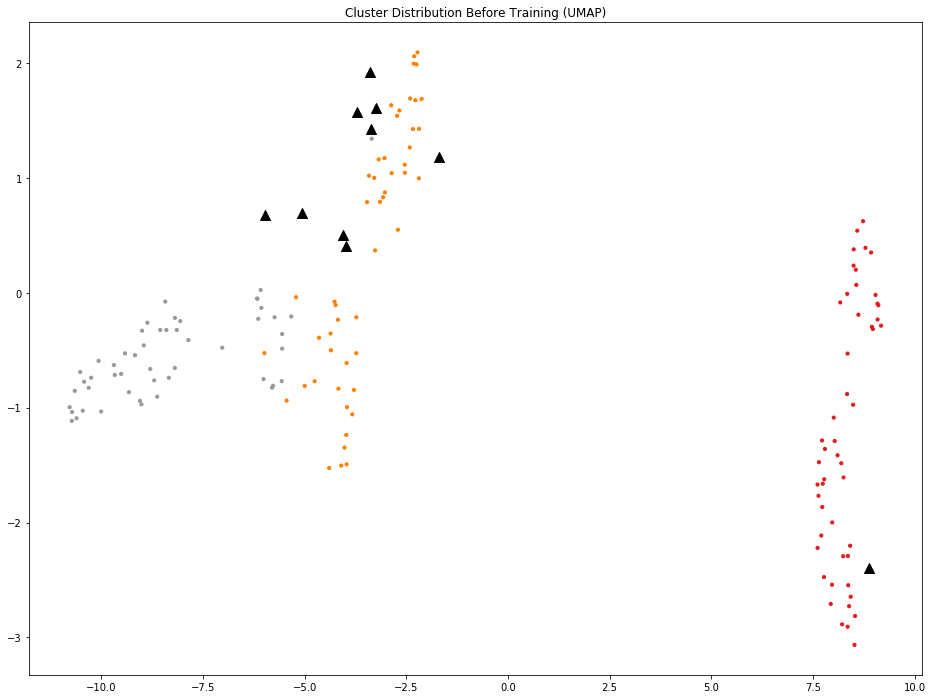

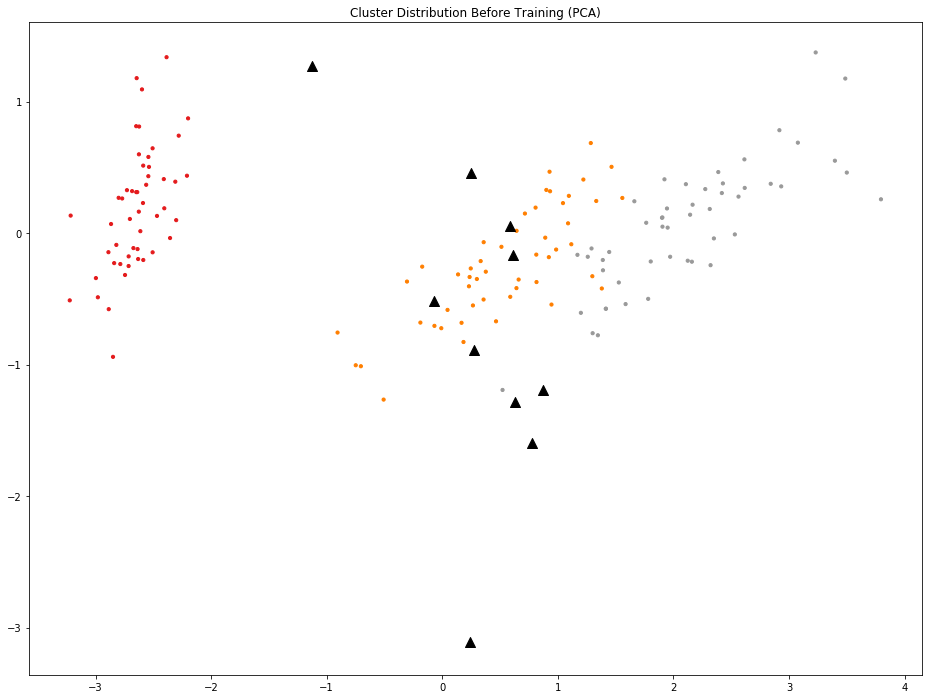

In [5]:
# initial values for the network parameters
init_mu = np.mean(X, axis=0, keepdims=True) + np.random.normal(0, 1, (10, 4))
init_sigma = np.ones((10, 4))

umap_init_mu = umap_reducer.transform(init_mu)
pca_init_mu = pca_reducer.transform(init_mu)

model = create_model()
model.layers[0].set_weights([init_mu, init_sigma])

plt.figure(figsize=(16, 12))
plt.title("Cluster Distribution Before Training (UMAP)")
plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(umap_init_mu[:,0], umap_init_mu[:,1], s=100, c="k", marker="^")

plt.figure(figsize=(16, 12))
plt.title("Cluster Distribution Before Training (PCA)")
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(pca_init_mu[:,0], pca_init_mu[:,1], s=100, c="k", marker="^")

The plots above shows the centers of the clusters visualized using both UMAP and PCA before the model is trained.

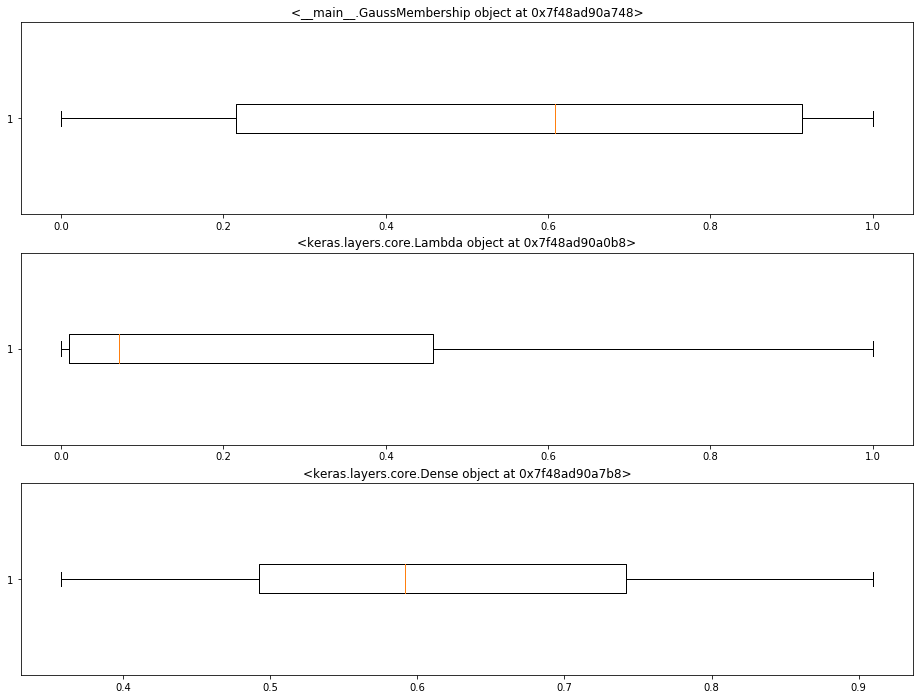

In [6]:
def plot_activations(model, inputs):
    fig, axes = plt.subplots(3, 1, squeeze=True, figsize=(16, 12))

    for ax, layer in zip(axes, model.layers):
        activation_fn = K.function(model.inputs, [layer.output])
        activation = activation_fn([inputs])[0]

        ax.set_title(layer)
        ax.boxplot(activation.reshape(-1), vert=False)


def plot_gradients(model, inputs):
    gradient_fn = K.function(model.inputs, K.gradients(model.output, model.trainable_weights))
    gradients = gradient_fn([inputs])
    
    fig, axes = plt.subplots(4, 1, squeeze=True, figsize=(16, 12))
    #plt.suptitle("Gradients Before Training")
            
    for ax, param, gradient in zip(axes, model.trainable_weights, gradients):
        ax.set_title(param)
        ax.boxplot(gradient.reshape(-1), vert=False)
        
    plt.tight_layout()
    

model = create_model()
model.layers[0].set_weights([init_mu, init_sigma])
plot_activations(model, X)

The boxplots above show the distributions of the models intermediate activations across all input examples.

W0206 17:18:20.724194 139952438126400 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


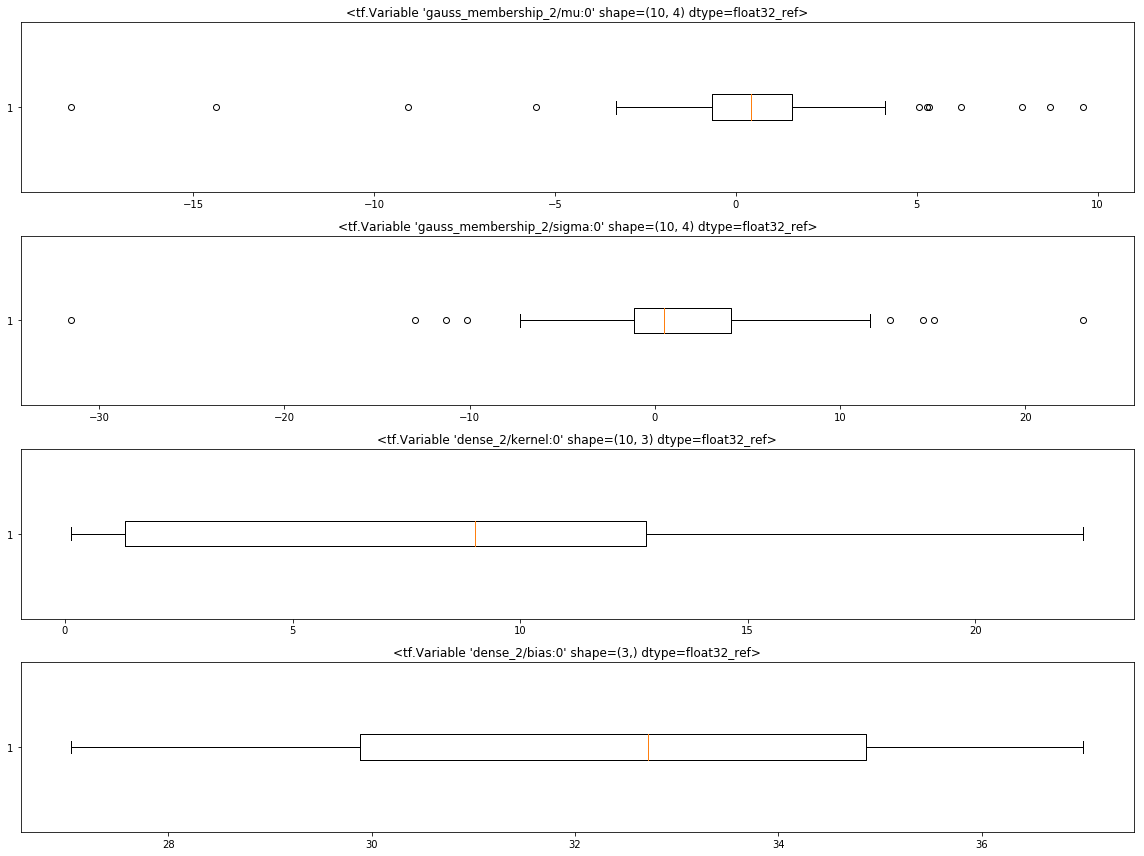

In [7]:
plot_gradients(model, X)

The gradient of each of the model's parameters are plotted above. The gradients were computed using all 150 samples from the dataset. There is no evidence of vanishing gradients.

The black triangles show the locations of the clusters before any training has been done. The initial values were chosen to fit the data and maximize training speed.

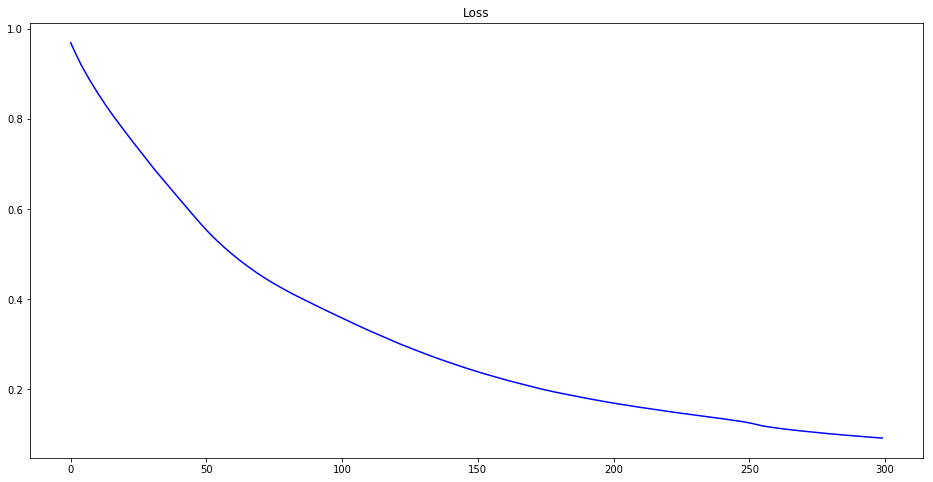

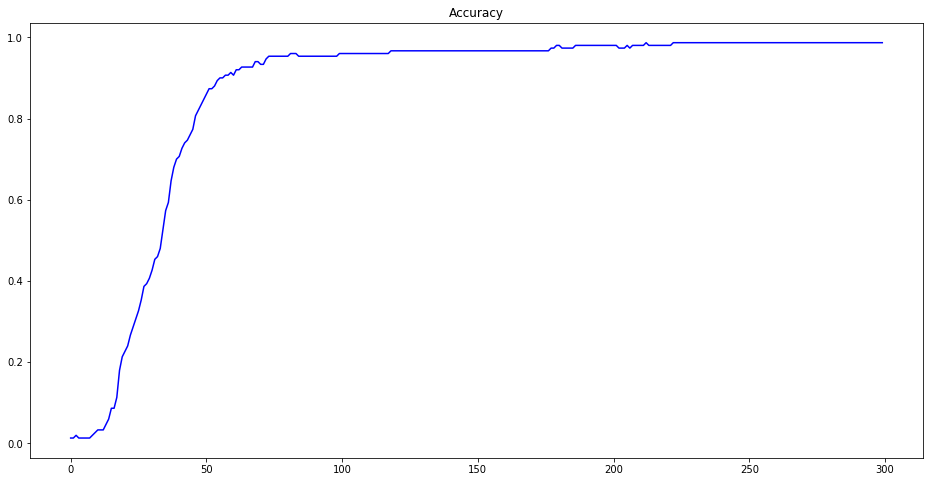

In [8]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

history = model.fit(
    x=X,
    y=Y,
    batch_size=32,
    epochs=300,
    verbose=0,
    shuffle=True)

plt.figure(figsize=(16, 8))
plt.title("Loss")
plt.plot(history.history["loss"], c="b")

plt.figure(figsize=(16, 8))
plt.title("Accuracy")
plt.plot(history.history["categorical_accuracy"], c="b")

The model was trained on the Iris dataset for 300 epochs with the loss and accuracy plotted above. No data was used as a validation set, as the performance of the model is not relevant to the purpose of this notebook.

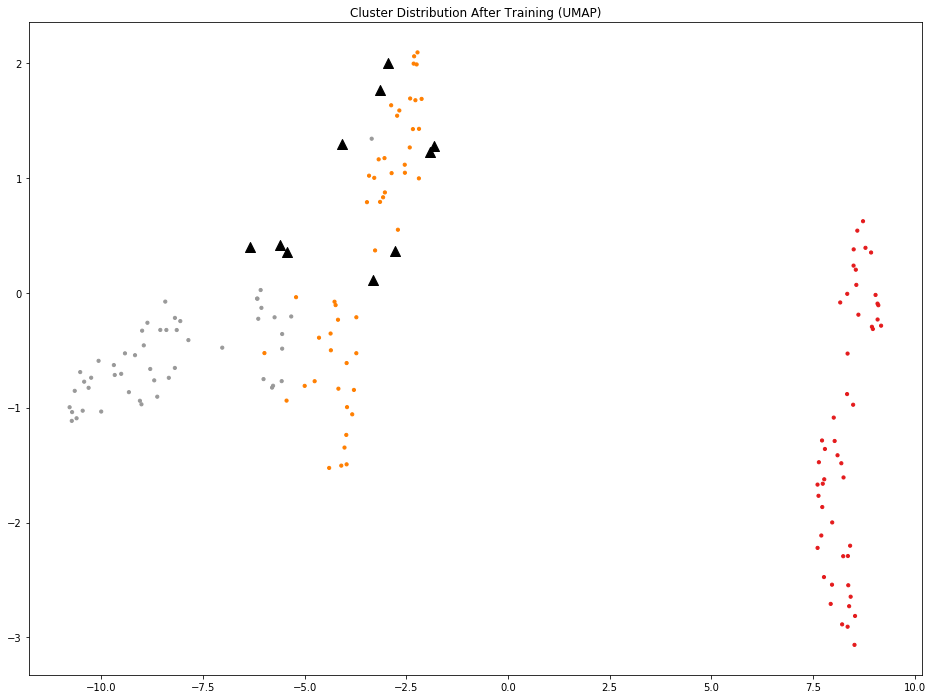

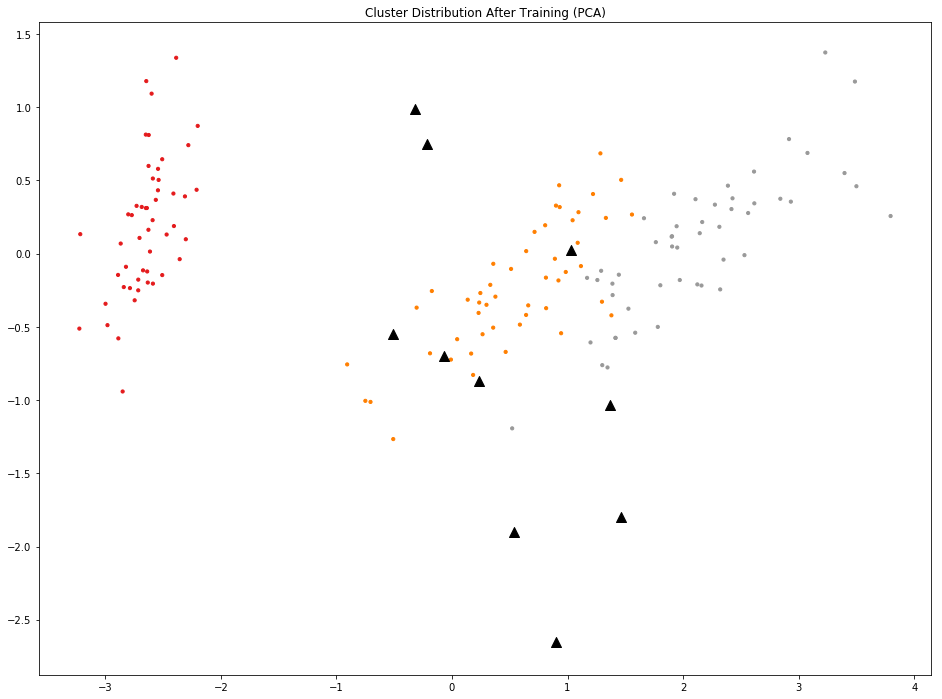

In [9]:
current_mu, current_sigma = model.layers[0].get_weights()
umap_current_mu = umap_reducer.transform(current_mu)
pca_current_mu = pca_reducer.transform(current_mu)

plt.figure(figsize=(16, 12))
plt.title("Cluster Distribution After Training (UMAP)")
plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(umap_current_mu[:,0], umap_current_mu[:,1], s=100, c="k", marker="^")

plt.figure(figsize=(16, 12))
plt.title("Cluster Distribution After Training (PCA)")
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(pca_current_mu[:,0], pca_current_mu[:,1], s=100, c="k", marker="^")

Compared to the previous plots it does not appear that the clusters have moved far from their initial locations. Additionally, the clusters do not move to what would be intuitive locations. Despite this, the model was able to fit the dataset well.

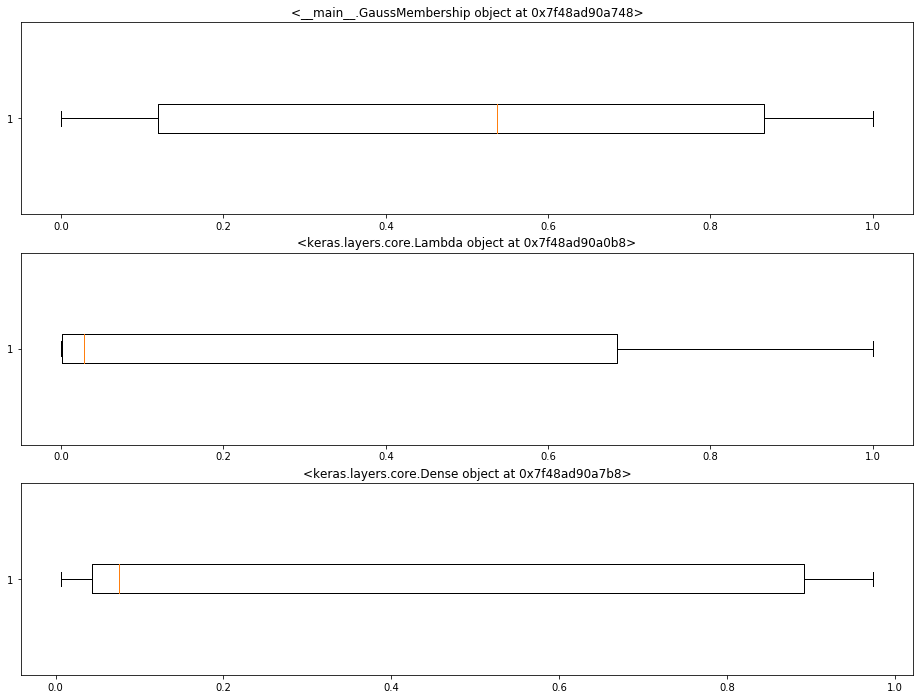

In [10]:
plot_activations(model, X)

As expected, the activations after training now display a higher likelihood to produce an activation of one.

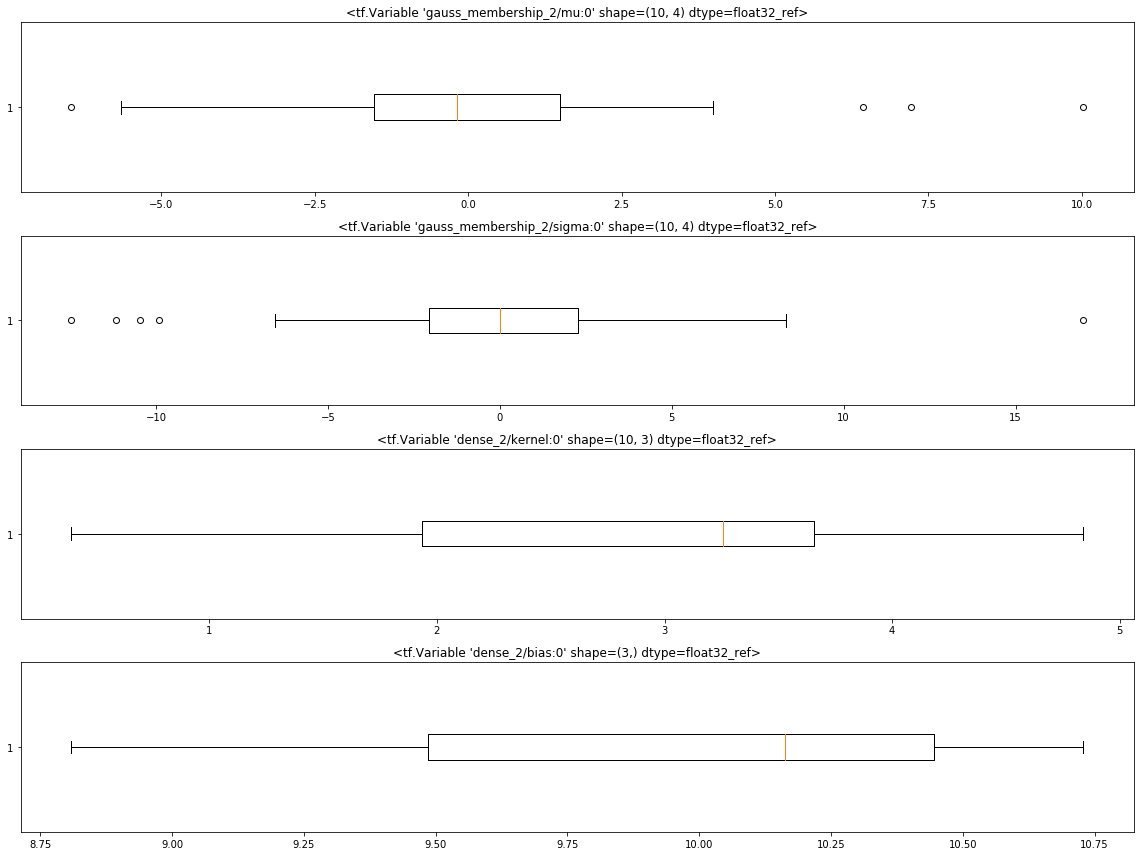

In [11]:
plot_gradients(model, X)

The model is likely approaching a local minimum as the gradients are getting smaller. The model could be trained further to determine if this changes the locations of the centers.

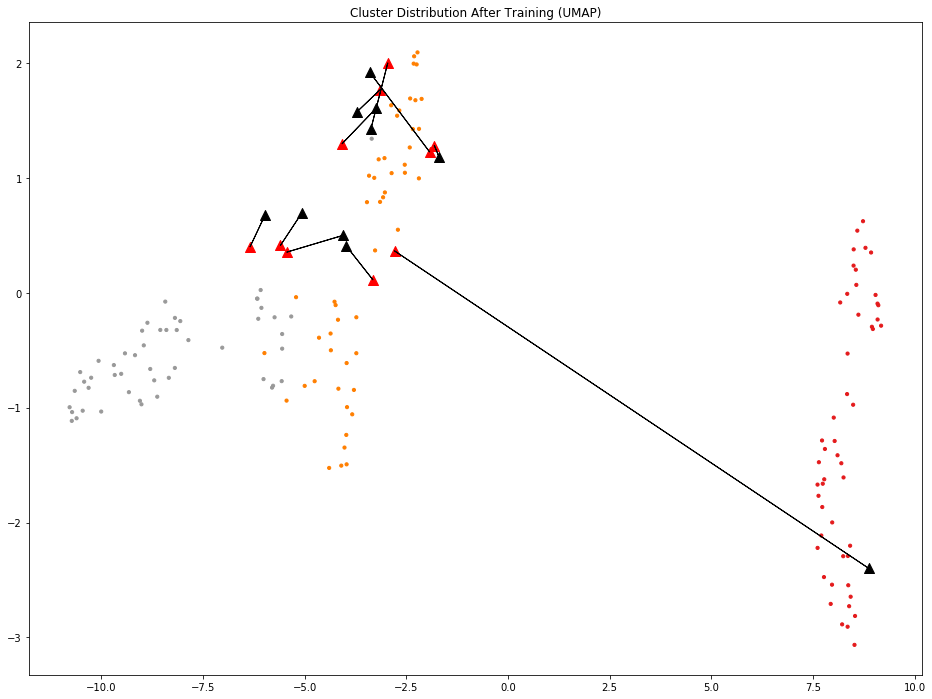

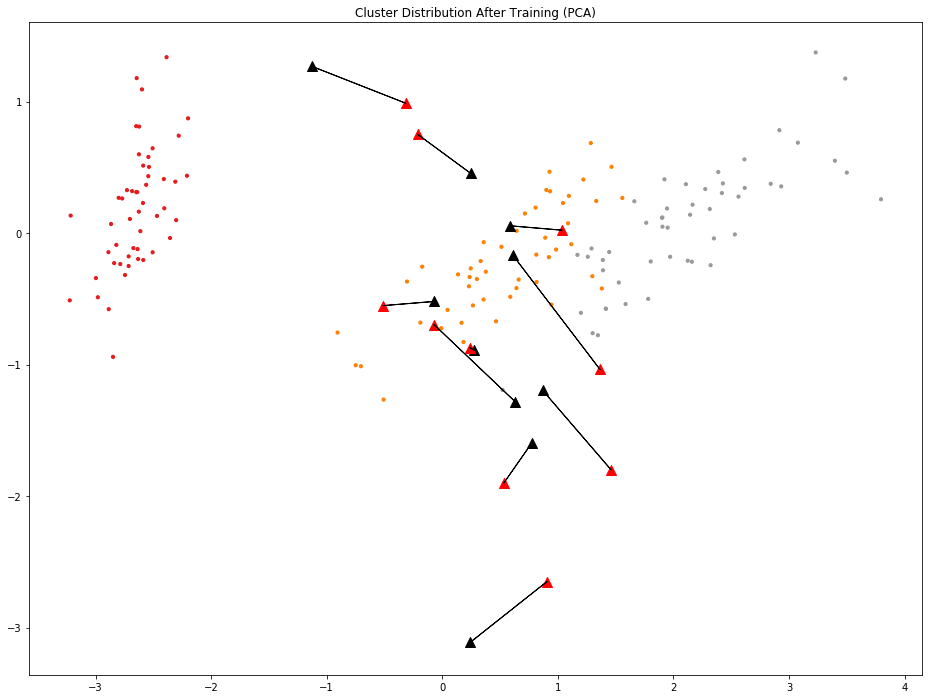

In [12]:
def plot_movements():
    umap_delta_mu = umap_current_mu - umap_init_mu
    pca_delta_mu = pca_current_mu - pca_init_mu

    plt.figure(figsize=(16, 12))
    plt.title("Cluster Distribution After Training (UMAP)")
    plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
    plt.scatter(umap_init_mu[:,0], umap_init_mu[:,1], s=100, c="k", marker="^")
    plt.scatter(umap_current_mu[:,0], umap_current_mu[:,1], s=100, c="r", marker="^")
    for i in range(umap_delta_mu.shape[0]):
        plt.arrow(umap_init_mu[i,0], umap_init_mu[i,1], umap_delta_mu[i,0], umap_delta_mu[i,1])

    plt.figure(figsize=(16, 12))
    plt.title("Cluster Distribution After Training (PCA)")
    plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
    plt.scatter(pca_init_mu[:,0], pca_init_mu[:,1], s=100, c="k", marker="^")
    plt.scatter(pca_current_mu[:,0], pca_current_mu[:,1], s=100, c="r", marker="^")
    for i in range(umap_delta_mu.shape[0]):
        plt.arrow(pca_init_mu[i,0], pca_init_mu[i,1], pca_delta_mu[i,0], pca_delta_mu[i,1])
    

plot_movements()

The plots above show the initial centers (in black) and their final location after training (in red) connected by an arrow.

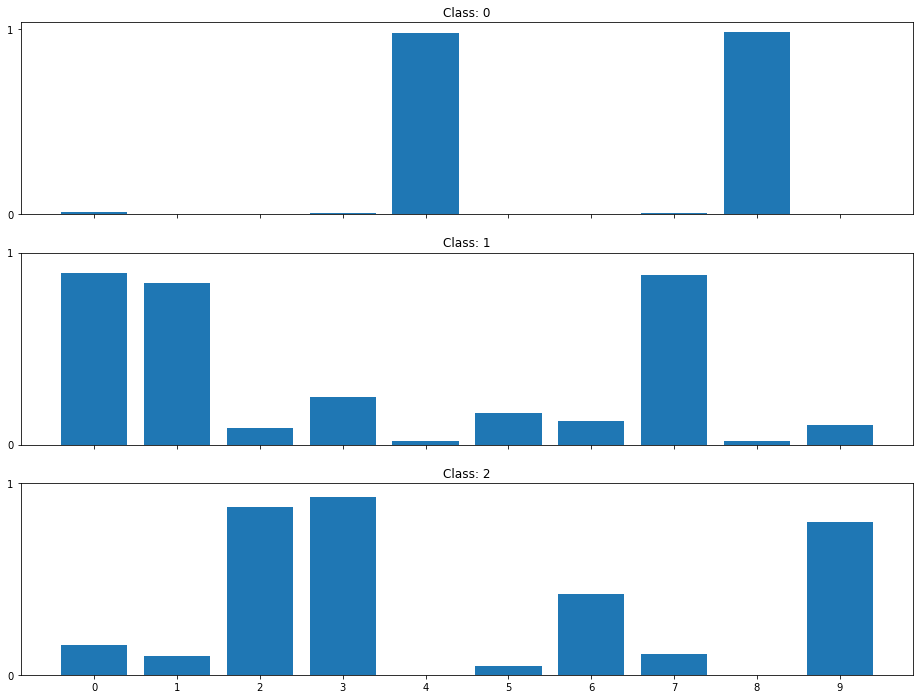

In [13]:
def average_fstrengths():
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(16,12))
    fstrength_fn = K.function(model.inputs, [model.layers[1].output])
    
    fstrength = fstrength_fn([X[classes == 0]])[0]
    ax0.set_title("Class: 0")
    ax0.bar(np.arange(10), np.mean(fstrength, axis=0))
    
    fstrength = fstrength_fn([X[classes == 1]])[0]
    ax1.set_title("Class: 1")
    ax1.bar(np.arange(10), np.mean(fstrength, axis=0))
    
    fstrength = fstrength_fn([X[classes == 2]])[0]
    ax2.set_title("Class: 2")
    ax2.bar(np.arange(10), np.mean(fstrength, axis=0))
    
    plt.setp([ax0, ax1, ax2], xticks=np.arange(10), yticks=[0,1])
    
    
average_fstrengths()

The bar charts above show the mean firing strength of each rule for the different classes. Despite the results found in the UMAP and PCA diagrams, each rule, or cluster, seems to have one class where it's firing strength is maximized.

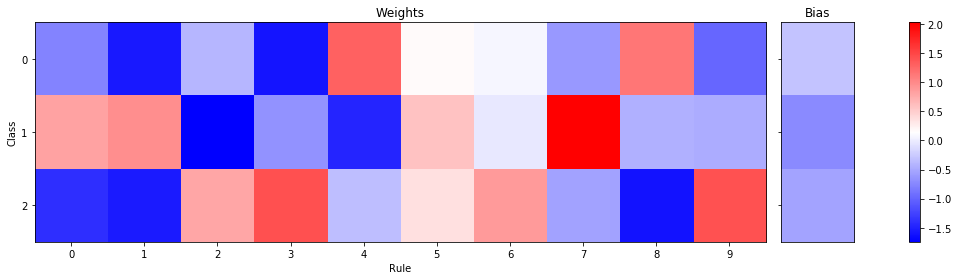

In [14]:
import matplotlib.gridspec as gridspec


kernel, bias = model.layers[2].get_weights()
fig, (ax0, ax1) = plt.subplots(
    1, 2, figsize=(16,4), sharey=True, squeeze=True, gridspec_kw={'width_ratios':[10, 1]})

im0 = ax0.imshow(kernel.T, cmap="bwr")
ax0.set_title("Weights")
ax0.set_ylabel("Class")
ax0.set_xlabel("Rule")
ax0.set_yticks(np.arange(3))
ax0.set_xticks(np.arange(10))

ax1.imshow(bias.reshape(3,1), cmap="bwr", vmin=np.min(kernel), vmax=np.max(kernel))
ax1.set_title("Bias")
ax1.set_xticks([])

plt.tight_layout()
fig.colorbar(im0, ax=[ax0, ax1])

The image above shows how the network uses the firing strenth of each rule to make predictions.

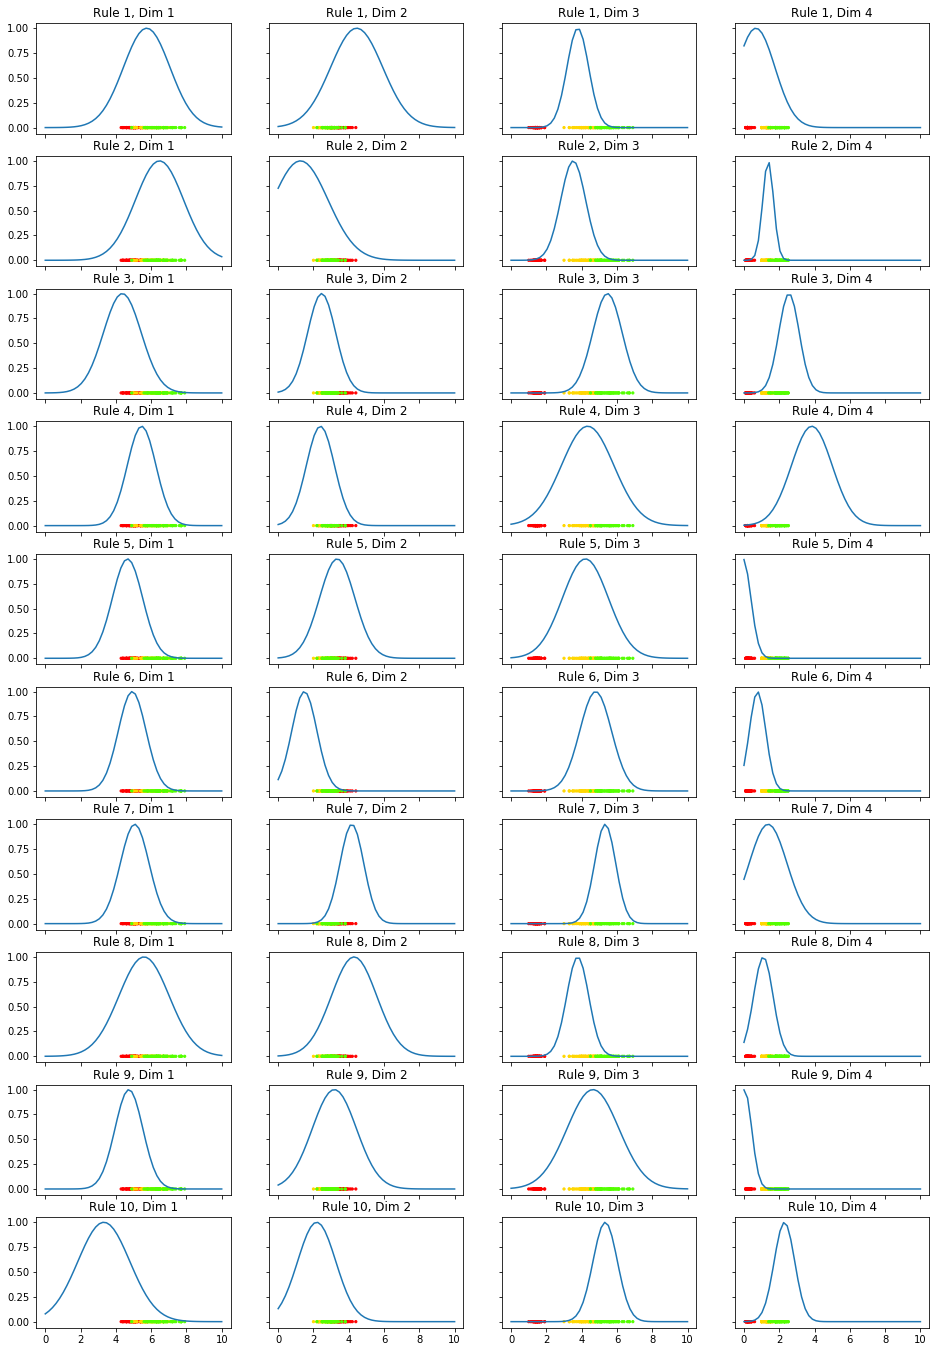

In [15]:
def plot_membership_fns():
    fig, axes = plt.subplots(10, 4, figsize=(16,24), sharex=True, sharey=True)
    mu, sigma = model.layers[0].get_weights()

    for dim in range(4):
        for rule in range(10):
            ax = axes[rule][dim]
            m, s = mu[rule][dim], sigma[rule][dim]

            x = np.linspace(0, 10)
            y = np.exp(-0.5 * np.square((x-m)/s))

            ax.plot(x, y)
            ax.scatter(X[:,dim], np.zeros((150)), s=5, c=classes, cmap="prism")
            ax.set_title("Rule {}, Dim {}".format(rule+1, dim+1))
            

plot_membership_fns()

class 0: green
class 1: yellow
class 2: red